# Discussion
### Mark Hendricks

## Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Data

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [3]:
info

,ETF Description
Symbol,
SPY,Domestic Equity SPDR S&P500
EFA,Foreign Equity iShares EAFE
EEM,iShares Emerging Markets
PSP,Private Equity Invesco Global Private Equity
QAI,Absolute Return IQ Multi-Strat
HYG,High Yield iShares High Yield Corporate Bond
DBC,Invesco DB Commodity Index Tracking Fund
IYR,Real Estate iShares US Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury


In [4]:
retsx

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0988,0.1146,0.1550,0.2296,0.0223,0.1379,-0.0016,0.2956,-0.0280,0.0084,-0.0185
2009-05-31,0.0589,0.1324,0.1599,0.0544,0.0283,0.0290,0.1631,0.0232,-0.0203,0.0541,0.0204
2009-06-30,-0.0013,-0.0146,-0.0231,0.0448,-0.0040,0.0329,-0.0269,-0.0255,-0.0062,0.0046,0.0014
2009-07-31,0.0746,0.1004,0.1102,0.1433,0.0154,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0365,0.0446,-0.0136,0.0330,-0.0046,-0.0174,-0.0408,0.1315,0.0072,0.0072,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.0519,-0.0355,0.0006,-0.0852,-0.0199,-0.0257,0.0797,-0.0815,-0.0203,-0.0254,-0.0198
2022-02-28,-0.0292,-0.0339,-0.0428,-0.0732,-0.0064,-0.0082,0.0650,-0.0455,-0.0027,-0.0108,0.0089
2022-03-31,0.0380,0.0056,-0.0334,-0.0074,-0.0022,-0.0125,0.0921,0.0690,-0.0402,-0.0419,-0.0184


# Functions that will be useful
## Basic performance metrics

In [5]:
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

## Tangency portfolio

In [6]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

# Section 2 - Required Analysis
## 2.1

In [7]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1507,0.1420,1.0612,-0.1290,0.1268
HYG,0.0721,0.0857,0.8410,-0.1044,0.1379
IYR,0.1519,0.1828,0.8310,-0.2005,0.2956
TIP,0.0320,0.0455,0.7041,-0.0418,0.0396
PSP,0.1389,0.2172,0.6397,-0.2789,0.2296
EFA,0.0854,0.1604,0.5321,-0.1452,0.1429
QAI,0.0205,0.0484,0.4247,-0.0605,0.0340
IEF,0.0235,0.0586,0.4010,-0.0440,0.0461
EEM,0.0737,0.1932,0.3818,-0.1791,0.1628
DBC,0.0422,0.1811,0.2331,-0.1776,0.1631


## 2.2

MIN Correlation pair is ('DBC', 'IEF')
MAX Correlation pair is ('PSP', 'EFA')


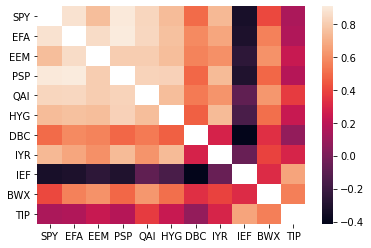

In [8]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. Furthermore, they have outperformed Domestic bonds in terms of mean and in terms of volatility.

Notably, TIPS have very low correlation to the other assets--including relatively low coorrelation to IEF (Domestic Bonds). In the correlation heat map above, we see that TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

## 2.3 The Tangency and the MV Frontier

In [9]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)
retsx_tan = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])

performanceMetrics(pd.concat([retsx,retsx_tan],axis=1),annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1507,0.1420,1.0612,-0.1290,0.1268
EFA,0.0854,0.1604,0.5321,-0.1452,0.1429
EEM,0.0737,0.1932,0.3818,-0.1791,0.1628
PSP,0.1389,0.2172,0.6397,-0.2789,0.2296
QAI,0.0205,0.0484,0.4247,-0.0605,0.0340
HYG,0.0721,0.0857,0.8410,-0.1044,0.1379
DBC,0.0422,0.1811,0.2331,-0.1776,0.1631
IYR,0.1519,0.1828,0.8310,-0.2005,0.2956
IEF,0.0235,0.0586,0.4010,-0.0440,0.0461
BWX,0.0064,0.0765,0.0835,-0.0694,0.0612


## Not Required - For Illustration

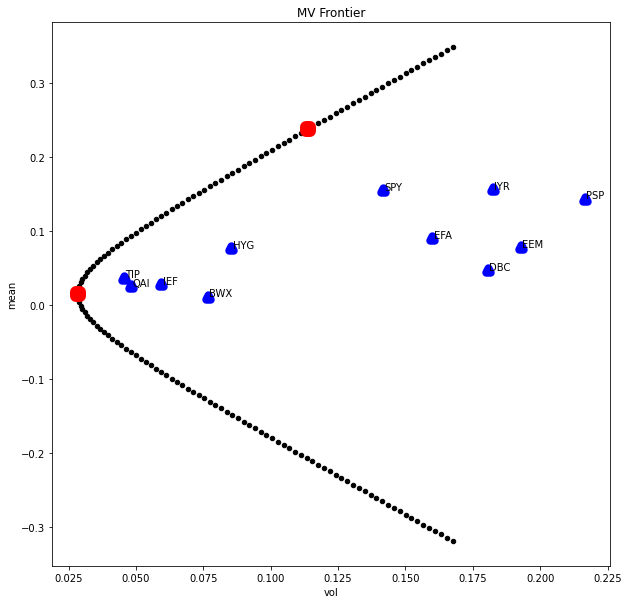

In [10]:
omega_tan = tangency_weights(rets)
rets_adj = rets - rets.mean() + 1
omega_gmv = tangency_weights(rets_adj)
omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-1.5,1.5,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = rets @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
    
rets_special = pd.DataFrame(index=rets.index)
rets_special['tan'] = rets @ omega_tan.values
rets_special['gmv'] = rets @ omega_gmv.values

mv_assets = pd.concat([rets.mean() * 12,rets.std() * np.sqrt(12)],axis=1)
mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

### How similar are tangency to 0 (in total returns) and tangency to risk-free (excess returns)?

In [11]:
comp = pd.concat([wts['tangency'], omega['tangency']],axis=1)
comp.columns = ['tan.riskfree','tan.zero']
comp

print(f'Correlation between tangency weights in total and excess returns is {comp.corr().values[0,1]:.4f}.')

Correlation between tangency weights in total and excess returns is 0.9981.


## 2.4 The Allocation

In [12]:
target_mean = .01

mu_tan = retsx.mean() @ wts['tangency']
delta = target_mean / mu_tan

wts['optimal'] = wts['tangency'] * delta

# list the assets sharpe ratios in a column to demonstrate not highly correlated with optimal weights
comp = pd.concat([wts[['optimal']],mets['Sharpe']],axis=1)
corr_sharpe_wts = comp.corr().values[0][1]

comp.sort_values('optimal',ascending=False)

,optimal,Sharpe
SPY,0.8299,1.0612
IEF,0.7622,0.4010
HYG,0.4623,0.8410
TIP,0.3355,0.7041
DBC,0.0677,0.2331
EEM,0.0454,0.3818
EFA,-0.0026,0.5321
IYR,-0.1303,0.8310
PSP,-0.1410,0.6397
BWX,-0.3438,0.0835


In [13]:
print(f'Total share in risky assets is {delta:.4f}.\nTotal share in risk-free asset is {1-delta:.4f}')
print(f'Correlation between an assets Sharpe ratio and its weight is {corr_sharpe_wts:.4f}.')

Total share in risky assets is 0.3534.
Total share in risk-free asset is 0.6466
Correlation between an assets Sharpe ratio and its weight is 0.4141.


## 2.5 Simple Portfolios

In [14]:
wts['equal'] = 1/len(retsx.columns)
wts['parity'] = 1/retsx.std()
# rescale these to hit the target mean
wts[['equal','parity']] *= target_mean / (retsx.mean()@wts[['equal','parity']])

wts

,tangency,optimal,equal,parity
SPY,2.3485,0.8299,0.1505,0.1377
EFA,-0.0072,-0.0026,0.1505,0.1220
EEM,0.1284,0.0454,0.1505,0.1013
PSP,-0.3991,-0.1410,0.1505,0.0901
QAI,-4.3353,-1.5319,0.1505,0.4043
HYG,1.3083,0.4623,0.1505,0.2282
DBC,0.1917,0.0677,0.1505,0.1080
IYR,-0.3688,-0.1303,0.1505,0.1071
IEF,2.1571,0.7622,0.1505,0.3337
BWX,-0.9731,-0.3438,0.1505,0.2557


In [20]:
mets_full = performanceMetrics(retsx @ wts,annualization=12)
mets_full

,Mean,Vol,Sharpe,Min,Max
tangency,0.3396,0.1653,2.0545,-0.0910,0.1608
optimal,0.1200,0.0584,2.0545,-0.0322,0.0568
equal,0.1200,0.1626,0.7378,-0.1939,0.1526
parity,0.1200,0.1525,0.7867,-0.1749,0.1208


## For Illustration, not Required

### Suppose TIPS had a mean return 1% (annualized) higher than in the sample

* Would the weights change much?
* Would the MV frontier change much?

In [21]:
retsx_adj = retsx.copy()
retsx_adj['TIP'] += .01/12

wts_adj = wts[['tangency','optimal']].copy()
wts_adj['tangency adj'] = tangency_weights(retsx_adj)
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'],columns=['tangency adj'])

mu_adj = retsx_adj.mean()
mu_tan_adj = mu_adj @ wts_adj['tangency adj']
delta_adj = target_mean / mu_tan

wts_adj['optimal adj'] = wts_adj['tangency adj'] * delta_adj

wts_adj

,tangency,optimal,tangency adj,optimal adj
SPY,2.3485,0.8299,1.9464,0.6878
EFA,-0.0072,-0.0026,0.0805,0.0284
EEM,0.1284,0.0454,0.0598,0.0211
PSP,-0.3991,-0.1410,-0.3828,-0.1353
QAI,-4.3353,-1.5319,-3.7592,-1.3283
HYG,1.3083,0.4623,1.1680,0.4127
DBC,0.1917,0.0677,0.0924,0.0327
IYR,-0.3688,-0.1303,-0.3432,-0.1213
IEF,2.1571,0.7622,1.1679,0.4127
BWX,-0.9731,-0.3438,-0.8475,-0.2995


In [22]:
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj','optimal adj']], annualization=12)
pd.concat([mets_full.loc[['tangency','optimal']],mets_adj])

,Mean,Vol,Sharpe,Min,Max
tangency,0.3396,0.1653,2.0545,-0.0910,0.1608
optimal,0.1200,0.0584,2.0545,-0.0322,0.0568
tangency adj,0.3086,0.1437,2.1472,-0.0639,0.1552
optimal adj,0.1091,0.0508,2.1472,-0.0226,0.0548


In [23]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.4f}')
print(f'Proposed adjustment to mean of TIPS is {.01/12 : 0.4f}')

Standard error of mean of TIPS is equal to 0.0010
Proposed adjustment to mean of TIPS is  0.0008


## 2.6 Out-of-Sample Testing

In [24]:
retsx_IS = retsx.loc[:'2020']
retsx_OOS = retsx.loc['2021':]
wts_IS = tangency_weights(retsx.loc[:'2020'])
wts_IS.columns = ['mv']

wts_IS['equal'] = 1/len(retsx_IS.columns)
wts_IS['parity'] = 1/retsx_IS.std()
# rescale these to hit the target mean
wts_IS *= target_mean / (retsx_IS.mean()@ wts_IS)

wts_IS

,mv,equal,parity
SPY,0.7854,0.1397,0.1215
EFA,-0.0762,0.1397,0.1043
EEM,0.0271,0.1397,0.0860
PSP,-0.0248,0.1397,0.0791
QAI,-1.1978,0.1397,0.3516
HYG,0.4614,0.1397,0.1953
DBC,-0.0708,0.1397,0.0972
IYR,-0.2090,0.1397,0.0940
IEF,0.8448,0.1397,0.3024
BWX,-0.0390,0.1397,0.2304


In [25]:
port_IS = retsx_IS @ wts_IS

performanceMetrics(port_IS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,0.1200,0.0524,2.2899,-0.0187,0.0654
equal,0.1200,0.1545,0.7769,-0.1800,0.1417
parity,0.1200,0.1345,0.8922,-0.1525,0.1043


In [26]:
port_OOS = retsx_OOS @ wts_IS

performanceMetrics(port_OOS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,-0.0121,0.0982,-0.1233,-0.0711,0.0342
equal,0.0405,0.1208,0.3348,-0.0745,0.0534
parity,-0.0195,0.1197,-0.1631,-0.0878,0.0474


### Why does the MV Portfolio do worse?
#### It has a huge position in SPY, and SPY was the best performing asset in 2021!

In [27]:
performanceMetrics(retsx_OOS,annualization=12).sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
DBC,0.5027,0.1598,3.1458,-0.0871,0.1014
IYR,0.1489,0.1837,0.8103,-0.0815,0.0944
SPY,0.0976,0.1466,0.6655,-0.0875,0.0704
EFA,0.0059,0.1138,0.0517,-0.0671,0.0436
TIP,0.0017,0.0471,0.0370,-0.0215,0.0268
PSP,-0.0347,0.2099,-0.1655,-0.1254,0.0951
HYG,-0.0179,0.0564,-0.3175,-0.0415,0.0242
QAI,-0.0460,0.0389,-1.1828,-0.0331,0.0110
EEM,-0.1246,0.1040,-1.1982,-0.0644,0.0318
IEF,-0.0855,0.0642,-1.3302,-0.0420,0.0199
